#Importing Required Libraries
* Imporitng the required libraries and mounting the drive to train and evaluate the model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import os
from sklearn.model_selection import train_test_split

In [2]:
# Load teacher model
teacher_model_path = "/content/drive/MyDrive/PG-PROJECT/baseline_mlp_model.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Load data
X_train = np.load('/content/drive/MyDrive/PG-PROJECT/X_train.npy')
y_train = np.load('/content/drive/MyDrive/PG-PROJECT/y_train.npy')  # Integer labels
# Get input shape and number of classes
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))


In [3]:
# Only needed internally by KD class — stored separately if desired
teacher_soft_labels = teacher_model.predict(X_train, batch_size=32)

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [4]:
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

def build_compressed_student(input_shape, num_classes):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

student_model = build_compressed_student(input_shape, num_classes)

#Compressed Model Training

In [5]:
import tensorflow as tf
from tensorflow import keras

class Distiller(keras.Model):
    def __init__(self, student, teacher, temperature=3, alpha=0.5):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)
            s_loss = self.student_loss_fn(y, student_preds)
            d_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature),
                tf.nn.softmax(student_preds / self.temperature)
            ) * (self.temperature ** 2)
            loss = self.alpha * s_loss + (1 - self.alpha) * d_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_preds)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        student_preds = self.student(x, training=False)
        s_loss = self.student_loss_fn(y, student_preds)
        self.compiled_metrics.update_state(y, student_preds)

        return {m.name: m.result() for m in self.metrics}

In [6]:
# Create distiller instance
distiller = Distiller(
    student=student_model,
    teacher=teacher_model,
    temperature=3,
    alpha=0.5
)

# Compile with standard Keras options
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence()
)

# Fit it
distiller.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - sparse_categorical_accuracy: 0.5567 - loss: 0.1667
Epoch 2/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9275 - loss: 0.1667
Epoch 3/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9556 - loss: 0.1667
Epoch 4/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9594 - loss: 0.1667
Epoch 5/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9705 - loss: 0.1667
Epoch 6/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9751 - loss: 0.1667
Epoch 7/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - sparse_categorical_accuracy: 0.9777 - loss: 0.1667
Epoch 8/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - sparse_categorical_accuracy: 0.9789 - loss: 0.1667
Epoch 9/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - sparse_categorical_accuracy: 0.9830 - loss: 0.1667
Epoch 10/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_cate

In [7]:
results = distiller.evaluate(X_train, y_train)
print("KD Compressed MLP Evaluation:", results)

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - sparse_categorical_accuracy: 0.9934 - loss: 0.1667
KD Compressed MLP Evaluation: [<tf.Tensor: shape=(), dtype=float32, numpy=0.1666671186685562>, {'sparse_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9951198101043701>}]


In [10]:
# Predict using the student model
y_pred = np.argmax(student_model.predict(X_train), axis=1)


359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


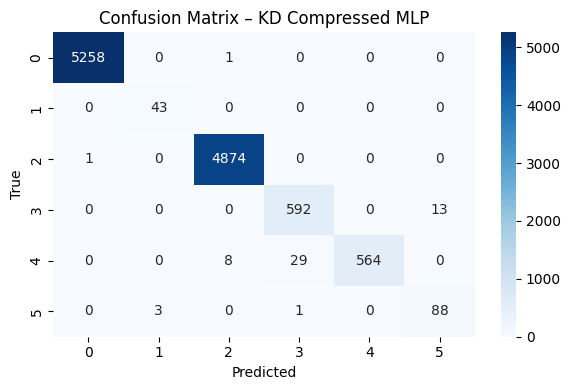

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5259
           1       0.93      1.00      0.97        43
           2       1.00      1.00      1.00      4875
           3       0.95      0.98      0.96       605
           4       1.00      0.94      0.97       601
           5       0.87      0.96      0.91        92

    accuracy                           1.00     11475
   macro avg       0.96      0.98      0.97     11475
weighted avg       1.00      1.00      1.00     11475



In [11]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – KD Compressed MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))


In [8]:
# Save student model
student_model.save("/content/drive/MyDrive/PG-PROJECT/KD_compressed_MLP.h5")

# Compare sizes
def get_model_size(path):
    size = os.path.getsize(path) / (1024 ** 2)
    print(f"{os.path.basename(path)} size: {size:.2f} MB")

get_model_size(teacher_model_path)
get_model_size("/content/drive/MyDrive/PG-PROJECT/KD_compressed_MLP.h5")

baseline_mlp_model.h5 size: 0.06 MB
KD_compressed_MLP.h5 size: 0.02 MB


In [9]:
def get_model_size(path):
    size = os.path.getsize(path) / (1024 ** 2)
    print(f"{os.path.basename(path)} size: {size:.2f} MB")

get_model_size("/content/drive/MyDrive/PG-PROJECT/baseline_mlp_model.h5")
get_model_size("/content/drive/MyDrive/PG-PROJECT/KD_compressed_MLP.h5")

baseline_mlp_model.h5 size: 0.06 MB
KD_compressed_MLP.h5 size: 0.02 MB
